<a href="https://colab.research.google.com/github/alonsosilvaallende/Churn-Prediction-in-a-Telco/blob/master/Churn-Prediction-in-a-Telco_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install lifelines and pysurvival
pip install -q lifelines pysurvival

In [0]:
# usual imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Churn prediction in a telco using random forests

Customer churn is the loss of clients or customers. In order to avoid losing customers, a company needs to examine why its customers have left in the past and which features are more important to determine who will churn next. Our task is therefore to predict whether customers are about to churn and which are the most important features to get that prediction. How can we use machine learning to better predict customer churn?

Given a dataset how can you evaluate if your churn predictions were right or not? Everybody will eventually churn (some people will change to a different company, some people will stop using the services altogether, and eventually all the people will churn if not because everybody eventually dies).
So the question remains, how do you evaluate if your churn predictions were right or wrong?

It has been argued elsewhere (see for example [here](https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/)) that the right approach to evaluate churn prediction models is through the concordance index and I'm convinced that it is a better approach than to treat it as a binary classification problem because of the reasons explained above (although you are free to try binary classification as well).
I think the right way to think about the problem is that given the customers our model has predicted to leave in a certain order, that that order has been right. The customers that were predicted to churn first have indeed churned first. Therefore, the right appoach is to evaluate our machine learning models is through the concordance index.

In this post, I will use different kinds of random forests to predict churn in a telco.

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/).

We will use that dataset to do our analysis. The dataset includes information about:

+ Customers who left within the last month – the column is called Churn
+ Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
+ Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
+ Demographic info about customers – gender, age range, and if they have partners and dependents

In [3]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


## Preprocessing

We first verify that there are no NaNs and there are no duplicated records.

In [4]:
# count how many NaN values does each feature/covariable have
churn_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Checking for duplicates
N_dupli = sum(churn_data.duplicated())
print(f'The data set contains {N_dupli} duplicates')

The data set contains 0 duplicates


In [7]:
N = churn_data.shape[0]
hasNotChurned = sum(churn_data['Churn']=='No')
hasChurned = sum(churn_data['Churn']=='Yes')

print(f'Number of samples: {N}')
print(f'Number of columns: {churn_data.shape[1]}')
print(f'Number of customers that have churned: {hasChurned}')
print(f'Number of customers that have not churned yet: {hasNotChurned}')
print(f'Percentage of customers that have churned: {100*hasChurned/len(churn_data):.0f}%')
print(f'Percentage of customers that have not churned yet: {100*hasNotChurned/len(churn_data):.0f}%')

Number of samples: 7043
Number of columns: 21
Number of customers that have churned: 1869
Number of customers that have not churned yet: 5174
Percentage of customers that have churned: 27%
Percentage of customers that have not churned yet: 73%


In the dataset, there are 7043 customers, of which 1869 customers have churned and 5174 customers that have not churned yet.

We drop the ID column and the TotalCharges column (otherwise by knowing the MonthlyCharges our model can easily deduce how many months someone has been subscribed)

In [0]:
# Drop customerID column
churn_data = churn_data.drop('customerID', axis=1)

# Drop TotalCharges column: otherwise together with MonthlyCharges you can deduce how many months you have been subscribed
churn_data = churn_data.drop('TotalCharges', axis=1)

In [9]:
churn_data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

### Convert object variables to numerical variables.

The column of Churn is an object data type, so we transform it to a numerical data type.

In [0]:
churn_data['Churn'] = churn_data['Churn'].map({'No': False, 'Yes': True})

We use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) for the categorical variables.

In [0]:
# creating one-hot columns
categories = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
churn_data = pd.get_dummies(churn_data, columns=categories, drop_first=True, dtype=float)

In [12]:
churn_data.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,34,56.95,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,2,53.85,True,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,45,42.30,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,2,70.70,True,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


We identify the time and event of interest columns.

In [0]:
# creating the time and event columns
event_col = 'Churn'
time_col = 'tenure'

# extracting the features/covariables
features = np.setdiff1d(churn_data.columns, [time_col, event_col]).tolist()

In [14]:
print(f'Number of features/covariables: {len(features)}')

Number of features/covariables: 28


## Data Analysis

We split the dataset into training (70%) and testing (30%) datasets.

In [0]:
# Building training and testing sets
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(N), test_size = 0.3, random_state=0)
data_train = churn_data.loc[index_train].reset_index(drop=True)
data_test  = churn_data.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_trn, X_val = data_train[features], data_test[features]
T_trn, T_val = data_train[time_col], data_test[time_col]
E_trn, E_val = data_train[event_col], data_test[event_col]

## Regression problem

In this post, I want to compare the performance of three different random forests:

+ Random forest classifier
+ Random forest regressor
+ Random survival forest

We want to determine from only the set of features/covariables who will churn first. There is no easy way to include in the learning of random forest classifier or random forest regressor both the events of interest (churn) and the times people have been subscribed.

Let's first consider only the case when they are using only one information

+ Random forest classifier will use the churn information
+ Random forest regressor will use the time information

and then we will compare with a combination of both random forest classifier and random forest regressor:

+ Random forest classifier will use the churn information and we will use that churn information to run a random forest regressor (we call that approach Random forest classifier-regressor).

+ Random forest regressor will use the time information and we will use that time information to run a random forest classifier (we call that approach Random forest regressor-classifier)

Concordance index of Random forest classifier: train: 0.917 valid: 0.765


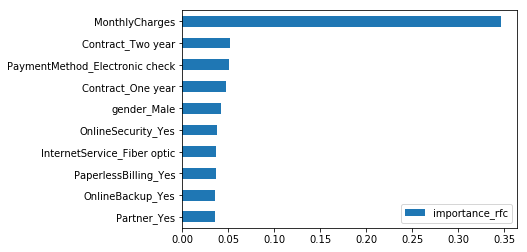

In [19]:
from sklearn.ensemble import RandomForestClassifier
from lifelines.utils import concordance_index

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn, E_trn)

ci_rfc_trn = concordance_index(T_trn, rfc.predict_proba(X_trn)[:,0], E_trn)
ci_rfc_val = concordance_index(T_val, rfc.predict_proba(X_val)[:,0], E_val)

print(f'Concordance index of Random forest classifier: train: {ci_rfc_trn:.3f} valid: {ci_rfc_val:.3f}')

# feature importance
fi_rfc = rfc.feature_importances_
rfi_rfc =  np.abs(fi_rfc)/np.sum(np.abs(fi_rfc))
lab = X_trn.columns
df_fi_rfc = pd.DataFrame(data={'importance_rfc': rfi_rfc}, index=lab)
df_fi_rfc = df_fi_rfc.sort_values(by='importance_rfc', ascending=True)[-10:]
df_fi_rfc.plot.barh(y='importance_rfc');

In [20]:
df_fi_rfc.sort_values(by='importance_rfc', ascending=False)

,importance_rfc
MonthlyCharges,0.346583
Contract_Two year,0.051150
PaymentMethod_Electronic check,0.050140
Contract_One year,0.046801
gender_Male,0.041857
OnlineSecurity_Yes,0.037556
InternetService_Fiber optic,0.036558
PaperlessBilling_Yes,0.036296
OnlineBackup_Yes,0.035264
Partner_Yes,0.034986


Concordance index of Random forest regressor: train: 0.919 valid: 0.817


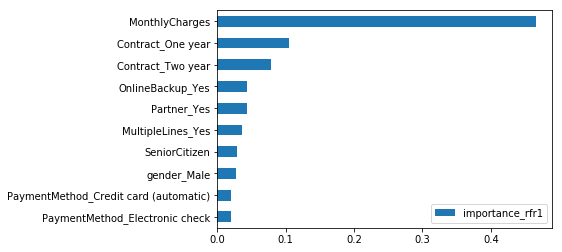

In [21]:
from sklearn.ensemble import RandomForestRegressor

rfr1 = RandomForestRegressor(n_estimators=100, random_state=42)

X_trn1 = X_trn[E_trn == True]
T_trn1 = T_trn[E_trn == True]
E_trn1 = E_trn[E_trn == True]

rfr1.fit(X_trn1, T_trn1)
ci_rfr1_trn = concordance_index(T_trn1, rfr1.predict(X_trn1), E_trn1)
ci_rfr1_val = concordance_index(T_val, rfr1.predict(X_val), E_val)

print(f'Concordance index of Random forest regressor: train: {ci_rfr1_trn:.3f} valid: {ci_rfr1_val:.3f}')

# feature importance
fi_rfr1 = rfr1.feature_importances_
rfi_rfr1 =  np.abs(fi_rfr1)/np.sum(np.abs(fi_rfr1))
lab = X_trn.columns
df_fi_rfr1 = pd.DataFrame(data={'importance_rfr1': rfi_rfr1}, index=lab)
df_fi_rfr1 = df_fi_rfr1.sort_values(by='importance_rfr1', ascending=True)[18:]
df_fi_rfr1.plot.barh(y='importance_rfr1');

In [22]:
df_fi_rfr1.sort_values(by='importance_rfr1', ascending=False)

,importance_rfr1
MonthlyCharges,0.466281
Contract_One year,0.105160
Contract_Two year,0.079135
OnlineBackup_Yes,0.043223
Partner_Yes,0.042977
MultipleLines_Yes,0.035529
SeniorCitizen,0.028447
gender_Male,0.027198
PaymentMethod_Credit card (automatic),0.019719
PaymentMethod_Electronic check,0.019448


Concordance index of Random forest regressor: train: 0.938 valid: 0.820


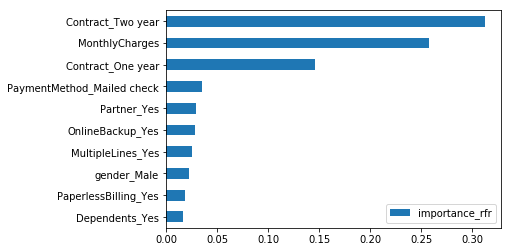

In [23]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_trn, T_trn)

ci_rfr_trn = concordance_index(T_trn, rfr.predict(X_trn), E_trn)
ci_rfr_val = concordance_index(T_val, rfr.predict(X_val), E_val)

print(f'Concordance index of Random forest regressor: train: {ci_rfr_trn:.3f} valid: {ci_rfr_val:.3f}')

# feature importance
fi_rfr = rfr.feature_importances_
rfi_rfr =  np.abs(fi_rfr)/np.sum(np.abs(fi_rfr))
lab = X_trn.columns
df_fi_rfr = pd.DataFrame(data={'importance_rfr': rfi_rfr}, index=lab)
df_fi_rfr = df_fi_rfr.sort_values(by='importance_rfr', ascending=True)[18:]
df_fi_rfr.plot.barh(y='importance_rfr');

In [24]:
df_fi_rfr.sort_values(by='importance_rfr', ascending=False)

,importance_rfr
Contract_Two year,0.312050
MonthlyCharges,0.257313
Contract_One year,0.145683
PaymentMethod_Mailed check,0.034982
Partner_Yes,0.028924
OnlineBackup_Yes,0.027996
MultipleLines_Yes,0.025800
gender_Male,0.022176
PaperlessBilling_Yes,0.019041
Dependents_Yes,0.016708


Concordance index of Random survival forest: train: 0.847, valid: 0.844


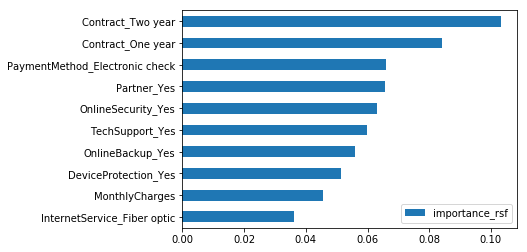

In [27]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=100)
rsf.fit(X_trn, T_trn, E_trn, seed=0)
ci_rsf_trn = concordance_index(T_trn, -rsf.predict_risk(X_trn), E_trn)
ci_rsf_val = concordance_index(T_val, -rsf.predict_risk(X_val), E_val)

print(f'Concordance index of Random survival forest: train: {ci_rsf_trn:.3f}, valid: {ci_rsf_val:.3f}')

# feature importance
fi_rsf = rsf.variable_importance_
rfi_rsf =  np.abs(fi_rsf)/np.sum(np.abs(fi_rsf))
lab = X_trn.columns
df_fi_rsf = pd.DataFrame(data={'importance_rsf': rfi_rsf}, index=lab)
df_fi_rsf = df_fi_rsf.sort_values(by='importance_rsf', ascending=True)[-10:]
df_fi_rsf.plot.barh(y='importance_rsf');

In [28]:
df_fi_rsf.sort_values(by='importance_rsf', ascending=False)

,importance_rsf
Contract_Two year,0.103379
Contract_One year,0.084170
PaymentMethod_Electronic check,0.066108
Partner_Yes,0.065598
OnlineSecurity_Yes,0.063223
TechSupport_Yes,0.059835
OnlineBackup_Yes,0.055889
DeviceProtection_Yes,0.051305
MonthlyCharges,0.045479
InternetService_Fiber optic,0.036056


## Random forest classifier-regressor

Predict the event and then compute the order.

In [29]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn, E_trn)

# add to X_val the predicted event
X_val_plus_E = X_val.copy()
X_val_plus_E[event_col] = rfc.predict(X_val)

# for the training dataset add the event column
feat_plus_E = np.union1d(features, [event_col])
X_trn_plus_E = data_train[feat_plus_E]

rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_trn_plus_E, T_trn)

ci_rfcr_trn = concordance_index(T_trn, rfr.predict(X_trn_plus_E), E_trn)
ci_rfcr_val = concordance_index(T_val, rfr.predict(X_val_plus_E), E_val)

print(f'Concordance index of Random forest classifier-regressor: train: {ci_rfcr_trn:.3f}, valid: {ci_rfcr_val:.3f}')

Concordance index of Random forest classifier-regressor: train: 0.957, valid: 0.689


## Random forest regressor-classifier

Predict the time and then the probability of the event.

In [30]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_trn, T_trn)

# add to X_val the predicted time
X_val_plus_T = X_val.copy()
X_val_plus_T[time_col] = rfr.predict(X_val)

# for the training dataset add the time column
feat_plus_T = np.union1d(features, [time_col])
X_trn_plus_T = data_train[feat_plus_T]

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_trn_plus_T, E_trn)

ci_rfrc_trn = concordance_index(T_trn, ~rfc.predict(X_trn_plus_T), E_trn)
ci_rfrc_val = concordance_index(T_val, ~rfc.predict(X_val_plus_T), E_val)
print(f'Concordance index of Random forest regressor-classifier: train: {ci_rfrc_trn:.3f}, valid: {ci_rfrc_val:.3f}')

Concordance index of Random forest regressor-classifier: train: 0.904, valid: 0.622


## Box plots

### Box plot classification

In [0]:
# choose 20 random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:20]

In [0]:
rfc_ci = []
rfr1_ci = []
rfr2_ci = []
rsf_ci = []

for _seed in seeds:
  index_train, index_test = train_test_split( range(N), test_size = 0.3, random_state=_seed)
  data_train = churn_data.loc[index_train].reset_index(drop=True)
  data_test  = churn_data.loc[index_test].reset_index(drop=True)

  # Creating the X, T and E inputs
  X_trn, X_val = data_train[features], data_test[features]
  T_trn, T_val = data_train[time_col], data_test[time_col]
  E_trn, E_val = data_train[event_col], data_test[event_col]

  rfc = RandomForestClassifier(n_estimators=100, random_state=42)
  rfc.fit(X_trn, E_trn)
  rfc_ci.append(concordance_index(T_val, rfc.predict_proba(X_val)[:,0], E_val))

  rfr1 = RandomForestRegressor(n_estimators=100, random_state=42)
  X_trn1 = X_trn[E_trn == True]
  T_trn1 = T_trn[E_trn == True]
  E_trn1 = E_trn[E_trn == True]
  rfr1.fit(X_trn1, T_trn1)
  rfr1_ci.append(concordance_index(T_val, rfr1.predict(X_val), E_val))

  rfr2 = RandomForestRegressor(n_estimators=100, random_state=42)
  rfr2.fit(X_trn, T_trn)
  rfr2_ci.append(concordance_index(T_val, rfr2.predict(X_val), E_val))

  rsf = RandomSurvivalForestModel(num_trees=100)
  rsf.fit(X_trn, T_trn, E_trn, seed=42)
  rsf_ci.append(concordance_index(T_val, -rsf.predict_risk(X_val), E_val))

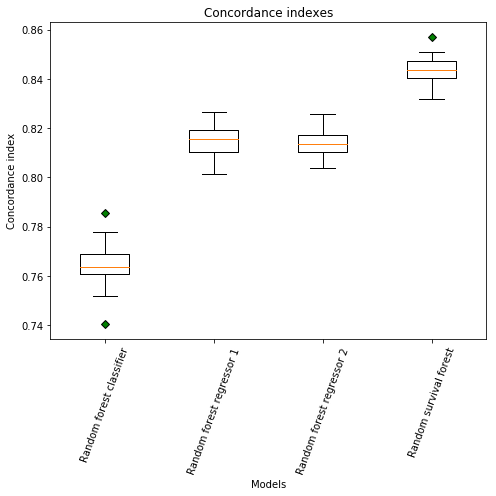

In [61]:
data = [rfc_ci, rfr1_ci, rfr2_ci, rsf_ci]
green_diamond = dict(markerfacecolor='g', marker='D')

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.set_title('Concordance indexes')
ax1.boxplot(data, notch=False, flierprops=green_diamond)
ax1.set_xticklabels(['Random forest classifier', 'Random forest regressor 1', 'Random forest regressor 2', 'Random survival forest'], rotation=70)
ax1.set_xlabel('Models')
ax1.set_ylabel('Concordance index')
plt.tight_layout()
plt.savefig('concordance.png', format='png', dpi=100)
# plt.show()